In [1]:
import torch
words = open('names.txt', 'r').read().splitlines()
#print(len(words), words[:5])

#split the data and create the trainingset and data set
stoi = {ch:i+1 for i,ch in enumerate(sorted(set("".join(words))))}
stoi['.'] = 0
itos = {i:ch for ch, i in stoi.items()}

In [2]:

def build_dataset(words):
    x = []
    y = []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            x.append(context)
            y.append(stoi[ch])
            context = context[1:] + [stoi[ch]]

    return torch.tensor(x), torch.tensor(y)

import random
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
x_training, y_training = build_dataset(words[:n1])
x_validation, y_validation = build_dataset(words[n1:n2])
x_test, y_test = build_dataset(words[n2:])

At initialization, the probability distribution is better to be distributed across all the characters
So we can have the initial loss at 1/27
Currently at initialization, the network is all messed up
We want to make b2 to be roughly zero, so can multiply by Zero
Make W2 closer to zero by multiplying with 0.1
Can we make Weights (W's) to Zero ?
For output layer it may be fine, but you may run into Vanishing gradients


Second issue is when the distribution of logits that have larger values (takes on extreme values) which means that the tanh will have the output of -1 or 1. This means the gradients will be zero- vanishing gradients and if for every example the gradient is zero the neurons will stop backpropagation which means the neurons are dead

Some of the neurons because of the way the non-linear functions work gets knocked out and then doesnt get activated again. They become dead. Initialization can help


During matrix multiplication, even if we have a gaussian distribution with std deviation 1 to start with, the gaussian expands and the std deviation increases. However, we would like to get unit gaussian throughout the neural net. In order to do this, we can multiply the weights by a number that can help preserve the unit gaussian nature. You can divide by the square root of the fanin to get a std deviation of one and this will preserve the unit gaussian nature in case of a tanh function 

We want to make sure the activations take reasonable value and not go to infinity. Everything negative is set to zero. For Relu you need to add a gain of 2. 

Initializing via Kining normal would be the right way to solve this. The gain factor is used to accommodate for the amount of activations that are thrown away by some of the functions

However, with modern innovations, many of these techniques for initializations are no longer a requirement
Residual connections
Batch normalization
Layer normalization
Much better optimizers such as Adam, rmsprop etc.

Batch normalization came out from a team at Google
We don't want the pre-activation to be too small or too large. So Batch normalization wants the hidden state to be unit gaussian, just do that
For each activation, normalize the value
subtract the mean and divide by standard deviation
Every neuron will have its firing rate as unit gaussian. We also want the values to move and shift. We do that my adding additional variable Gamma and Beta.The backpropagation should let us know how to move things around. This is called Scale and Shift. Scale by some gain (Gamma) and shift by the bias
bngain, bnbias 

However, now this introduces the issue that we are coupling the examples together in the batch whereas it was just an efficiency issue earlier. Logits become a function of all examples that come in the batch. This causes a jitter for h and logits and this side effect is good. This is kind of regularizer. It introduces a little bit of augmentation because of the introduction of this noise
No-one likes the property that the examples are coupled mathematically and this can introduce bugs etc. People have tried to deprecate

After the training is done, you keep the bnmean and bnstd deviation and this will help us to calculate during inference time
During batch normalization since you are adding the batch mean, the bias will be removed, so no need to have biases


Batch normalization is used to control the statistics of activations in the NN. it's common to sprinkle across the nn. It is placed after the linear layer or convolution layer. They have two buffers (running mean and std) and parameters for the gain and bias that are trained
running mean and std aren't trained. 
It's ca


In [15]:
vocab_size = 27
n_embd = 10
n_hidden = 200
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn(((block_size * n_embd), n_hidden), generator=g) * ((5/3) / ((block_size * n_embd) ** 0.5))
b1 = torch.randn(n_hidden, generator=g) * 0.01 
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0
bngain = torch.ones(1, n_hidden)
bnshift = torch.zeros(1, n_hidden)
bnmean_running = torch.zeros(1, n_hidden)
bnstd_running = torch.ones(1, n_hidden)

X = x_training
Y = y_training
print(X.shape)
parameters = [C, W1, b1, W2, b2, bngain, bnshift]

for p in parameters:
    p.requires_grad = True

torch.Size([182511, 3])


In [16]:
batch_size = 32
max_steps = 200000

lossi = []

import torch.nn.functional as F
#Create a batch and pick those items to train
for i in range(max_steps):
    #Create forwardpass, loss function and backward prop
    idx = torch.randint(0, X.shape[0], (batch_size,), generator=g)
    xb, yb = X[idx], Y[idx]
    emb = C[xb]
    #Linear layer
    embcat = emb.view(-1, block_size*n_embd)
    hpreact = embcat @ W1 + b1
    
    #Batchnorm layer
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * ((hpreact - bnmeani)/bnstdi) + bnshift
    with torch.no_grad ():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    #Non-linearity
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    #In simple terms, logits are the raw, unnormalized predictions generated by a model before applying any activation function. 
    # They represent the linear output of a model before it is transformed into probabilities.
    #We want the logits to be roughly zero or equal at initialization
    #
     
    #counts = hout.exp()
    #probs = counts/counts.sum(1, keepdim=True)
    #loss = -probs.log().mean()
    loss = F.cross_entropy(logits, yb)
    for p in parameters:
        p.grad = None
    loss.backward ()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    if i%10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    


      0/ 200000: 3.3111
  10000/ 200000: 2.3945
  20000/ 200000: 2.3379
  30000/ 200000: 2.1536
  40000/ 200000: 2.1076
  50000/ 200000: 2.3935
  60000/ 200000: 2.3470
  70000/ 200000: 2.3513
  80000/ 200000: 2.5621
  90000/ 200000: 2.0473
 100000/ 200000: 2.3962
 110000/ 200000: 1.8718
 120000/ 200000: 2.2942
 130000/ 200000: 1.7719
 140000/ 200000: 2.1954
 150000/ 200000: 1.9408
 160000/ 200000: 2.1260
 170000/ 200000: 2.1025
 180000/ 200000: 2.1937
 190000/ 200000: 1.8628


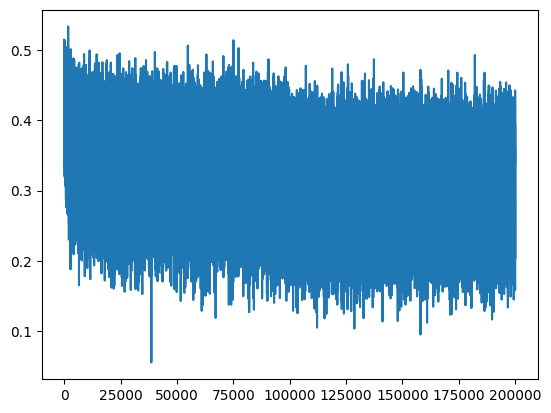

In [7]:
import matplotlib.pyplot as plt
#plt.hist(hpreact.view(-1).tolist(), 50)
#plt.figure(figsize=(20,10))
#plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
plt.plot(lossi)

In [ ]:
#Calibrate batch norm statistics
with torch.no_grad ():
    emb = C[X]
    embcat = emb.view(X.shape[0], -1)
    hpreact = embcat @ W1 + b1
    #Measure the mean and std over the training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std (0, keepdim=True)

print(bnmean)
print(bnmean_running)
print(bnstd)
print(bnstd_running)


In [21]:
@torch.no_grad
def split_loss(split):
    x, y = {
        'training': (x_training, y_training),
        'validation': (x_validation, y_validation),
        'test': (x_test, y_test),
    }[split]

    emb = C[x]
    embcat = emb.view(x.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean_running)/bnstd_running + bnshift
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss = {loss.item()}')
    return loss

split_loss('training')
split_loss ('validation')


training loss = 2.0645878314971924
validation loss = 2.10513973236084


tensor(2.1051)

In [ ]:
for i in range(5):
    context = [0] * 3
    name = ""
    while True:
        emb = C[context]
        hpreact = bngain * ((emb.view(-1, block_size*n_embd) @ W1 + b1) - bnmean/bnstd) + bnshift
        hinp = torch.tanh(hpreact)
        logits = hinp @ W2 + b2
        counts = logits.exp()
        probs = counts/counts.sum(1, keepdim=True)
        idx = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        context = context[1:] + [idx]
        if idx == 0:
            break
        else:
            name += itos[idx]
    print(name)

In [3]:
vocab_size = 27
n_embd = 10
n_hidden = 200
g = torch.Generator().manual_seed(2147483647)

In [21]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None        
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        parameters = [self.weight] + ([] if self.bias is None else [self.bias])
        return parameters

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.momentum = momentum
        self.eps = eps
        self.training = True
        
        self.gamma = torch.randn(dim, generator=g)
        self.beta = torch.zeros(dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        

    def __call__(self, x):
        if (self.training):
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean)/torch.sqrt (xvar + self.eps)        
        self.out = self.gamma * xhat + self.beta
        if (self.training):
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [24]:
C = torch.randn((vocab_size, n_embd), generator=g)
'''
layers = [
    Linear(n_embd * block_size, n_hidden),
    BatchNormal1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
]
'''
layers = [
    Linear(n_embd*block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size),
]
with torch.no_grad():
    #layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if (isinstance(layer, Linear)):
            layer.weight *= 5/3
    

parameters = [C] + [p for layer in layers for p in layer.parameters()]
for p in parameters:
    p.requires_grad = True

In [38]:
import torch.nn.functional as F

X = x_training
Y = y_training

max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    idx = torch.randint(0, X.shape[0], (batch_size,), generator=g)
    xb, yb = X[idx], Y[idx]
    emb = C[xb]
    x = emb.view(xb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, yb)

    for layer in layers:
        layer.out.retain_grad()

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if (i%10000 == 0):
        print(f'{i:7d}/{max_steps:7d}: {loss.item():0.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

      0/ 200000: 2.4426
  10000/ 200000: 2.3952
  20000/ 200000: 2.1894
  30000/ 200000: 2.1066
  40000/ 200000: 2.2167
  50000/ 200000: 2.0147
  60000/ 200000: 2.1798
  70000/ 200000: 2.2542
  80000/ 200000: 1.8008
  90000/ 200000: 1.9775
 100000/ 200000: 2.1324
 110000/ 200000: 1.8578
 120000/ 200000: 2.1124
 130000/ 200000: 2.1718
 140000/ 200000: 2.1681
 150000/ 200000: 2.2080
 160000/ 200000: 1.7753
 170000/ 200000: 1.7482
 180000/ 200000: 1.8834
 190000/ 200000: 2.4493


layer 1 (      Tanh): mean -0.11, std 0.94, saturated: 63.50%
layer 4 (      Tanh): mean +nan, std nan, saturated: 0.00%


RuntimeError: torch.histogramdd: dimension 0's range [nan, nan] is not finite

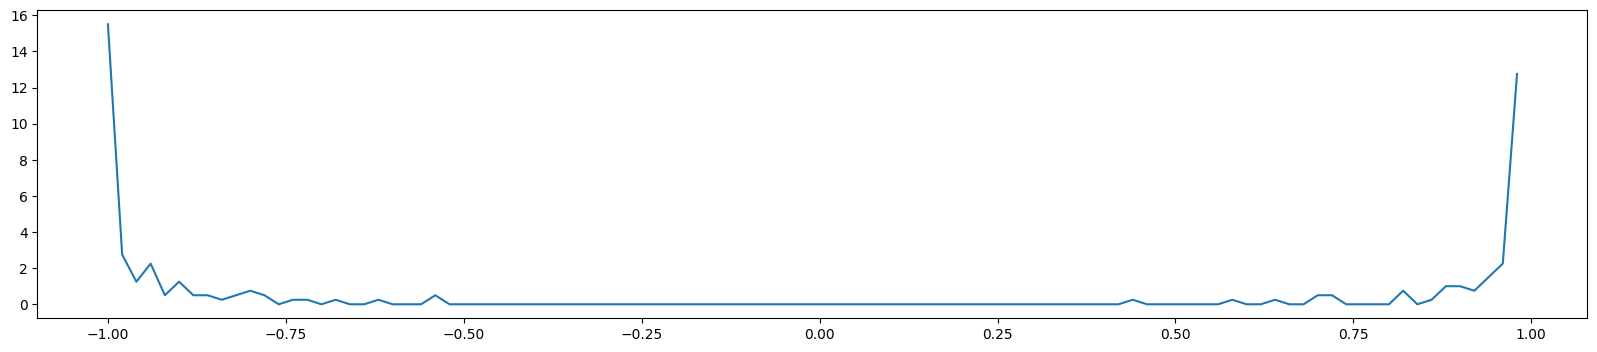

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach (), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution')


layer 1 (      Tanh): mean +0.000000, std 2.088453e-03
layer 4 (      Tanh): mean -0.000000, std 2.256039e-03
layer 7 (      Tanh): mean +0.000000, std 1.943428e-03
layer 10 (      Tanh): mean -0.000000, std 1.757316e-03
layer 13 (      Tanh): mean +0.000000, std 1.740308e-03


Text(0.5, 1.0, 'gradient distribution')

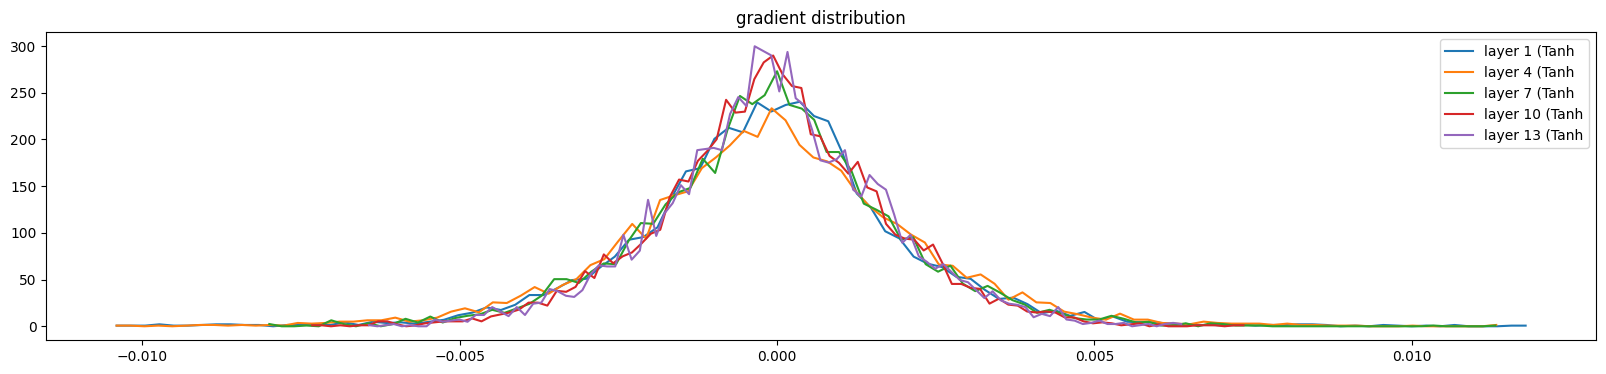

In [32]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000217 | std 1.153089e-02 | grad:data ratio 1.154991e-02
weight  (30, 200) | mean +0.000143 | std 5.851686e-03 | grad:data ratio 1.898065e-02
weight (200, 200) | mean +0.000034 | std 4.369433e-03 | grad:data ratio 3.685749e-02
weight (200, 200) | mean +0.000060 | std 3.483851e-03 | grad:data ratio 2.936598e-02
weight (200, 200) | mean +0.000001 | std 3.170591e-03 | grad:data ratio 2.697757e-02
weight (200, 200) | mean -0.000001 | std 2.822562e-03 | grad:data ratio 2.404162e-02
weight  (200, 27) | mean -0.000102 | std 7.694107e-03 | grad:data ratio 6.453687e-02


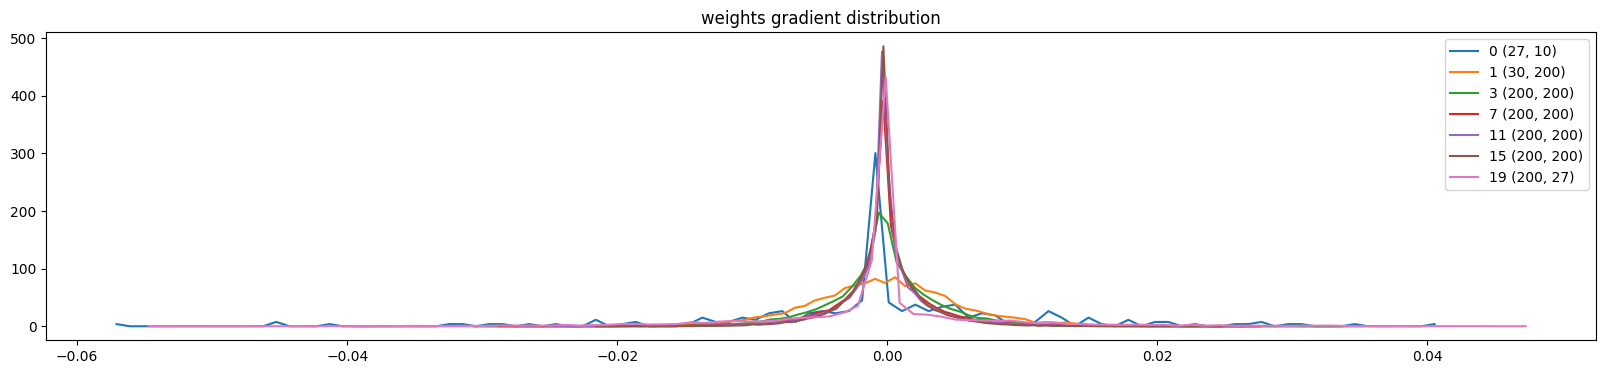

In [33]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

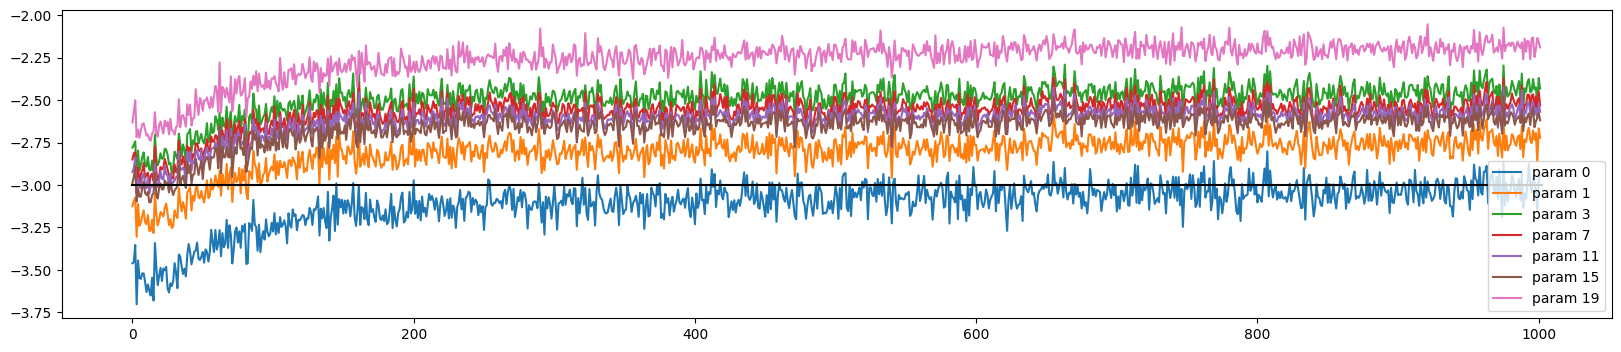

In [34]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [1]:
block_size = 3

for layer in layers:
    layer.training = False
    
for i in range(5):
    context = [0] * 3
    name = ""
    while True:
        emb = C[context]
        x = emb.view(-1, block_size*n_embd)
        print(x)
        for layer in layers:
            x = layer(x)
        print(x)
        with torch.no_grad():
            #layers[-1].weight *= 0.1
            layers[-1].gamma *= 0.1
            for layer in layers[:-1]:
                if (isinstance(layer, Linear)):
                    layer.weight *= 5/3
        #hpreact = bngain * ((emb.view(-1, block_size*n_embd) @ W1 + b1) - bnmean/bnstd) + bnshift
        #hinp = torch.tanh(hpreact)
        logits = x
        counts = logits.exp()
        probs = counts/counts.sum(1, keepdim=True)
        print(probs)
        idx = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        context = context[1:] + [idx]
        if idx == 0:
            break
        else:
            name += itos[idx]
    print(name)

NameError: name 'layers' is not defined